
Reading file:  C:\Users\asg_a_1p8y6mm\OneDrive\Desktop\WIOA Training\DataAnalytics\Module 7\Module 7; Class Project\Data Cleaning 2014\survey.csv
Shape - default:  (1259, 27)
Shape - filtered:  (1259, 27)
Shape - column filtered:  (1259, 25)
Shape - combined data:  (1259, 25)
Shape - combined data:  (1259, 25)
   Age  Gender         Country state self-employed family history treatment  \
0   37  Female   United States    IL           NaN             No       Yes   
1   44       M   United States    IN           NaN             No        No   
2   32    Male          Canada   NaN           NaN             No        No   
3   31    Male  United Kingdom   NaN           NaN            Yes       Yes   
4   31    Male   United States    TX           NaN             No        No   
5   33    Male   United States    TN           NaN            Yes        No   
6   35  Female   United States    MI           NaN            Yes       Yes   
7   39       M          Canada   NaN           NaN     

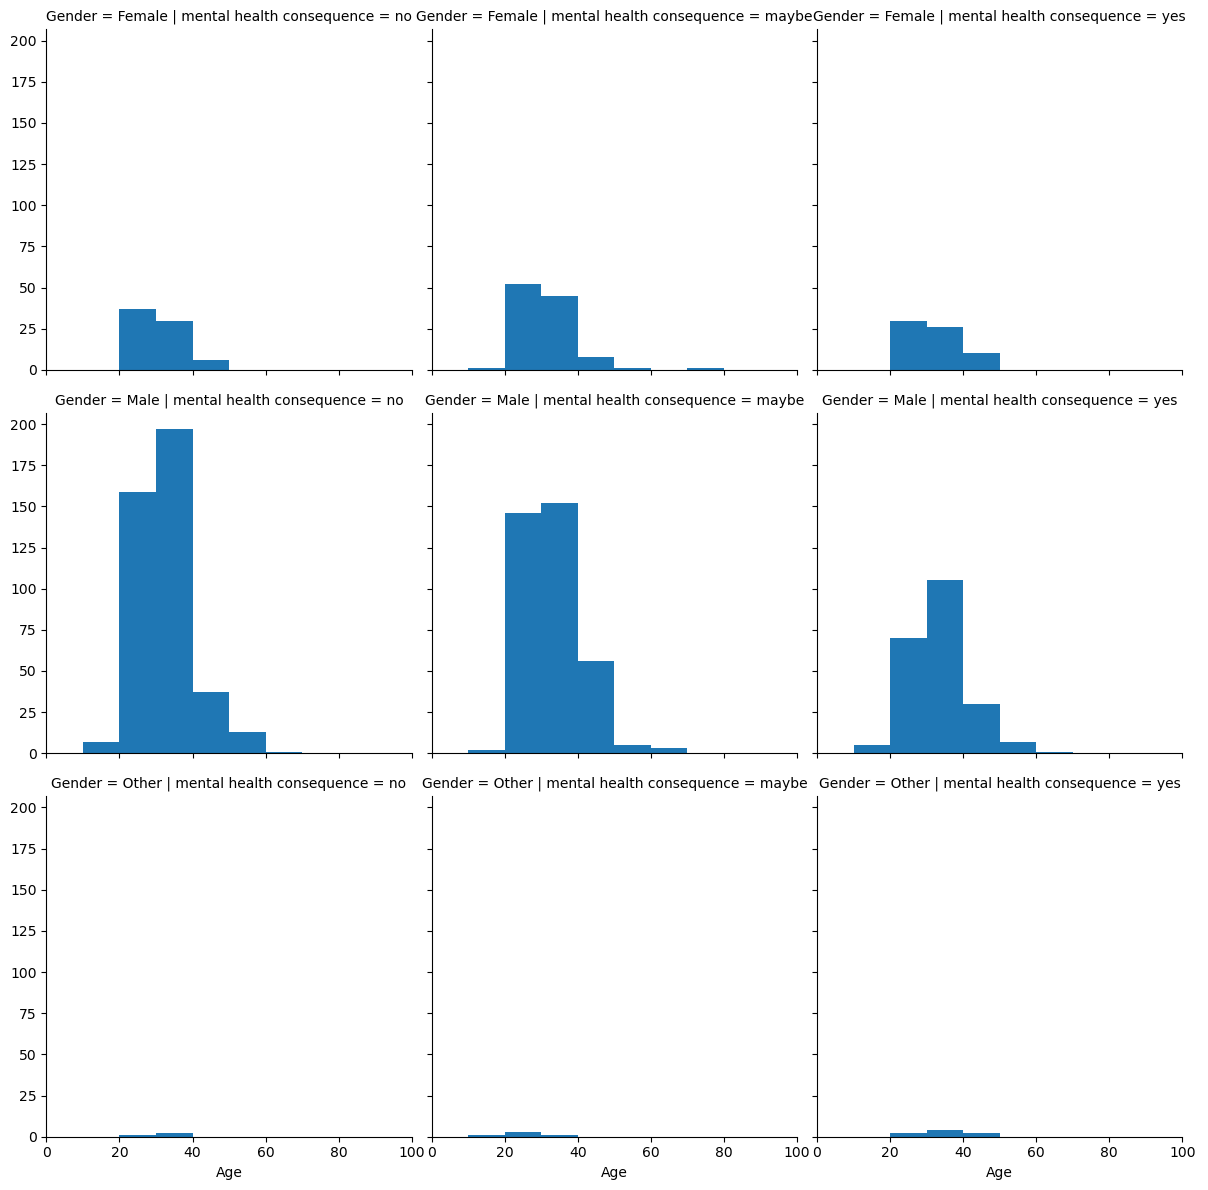

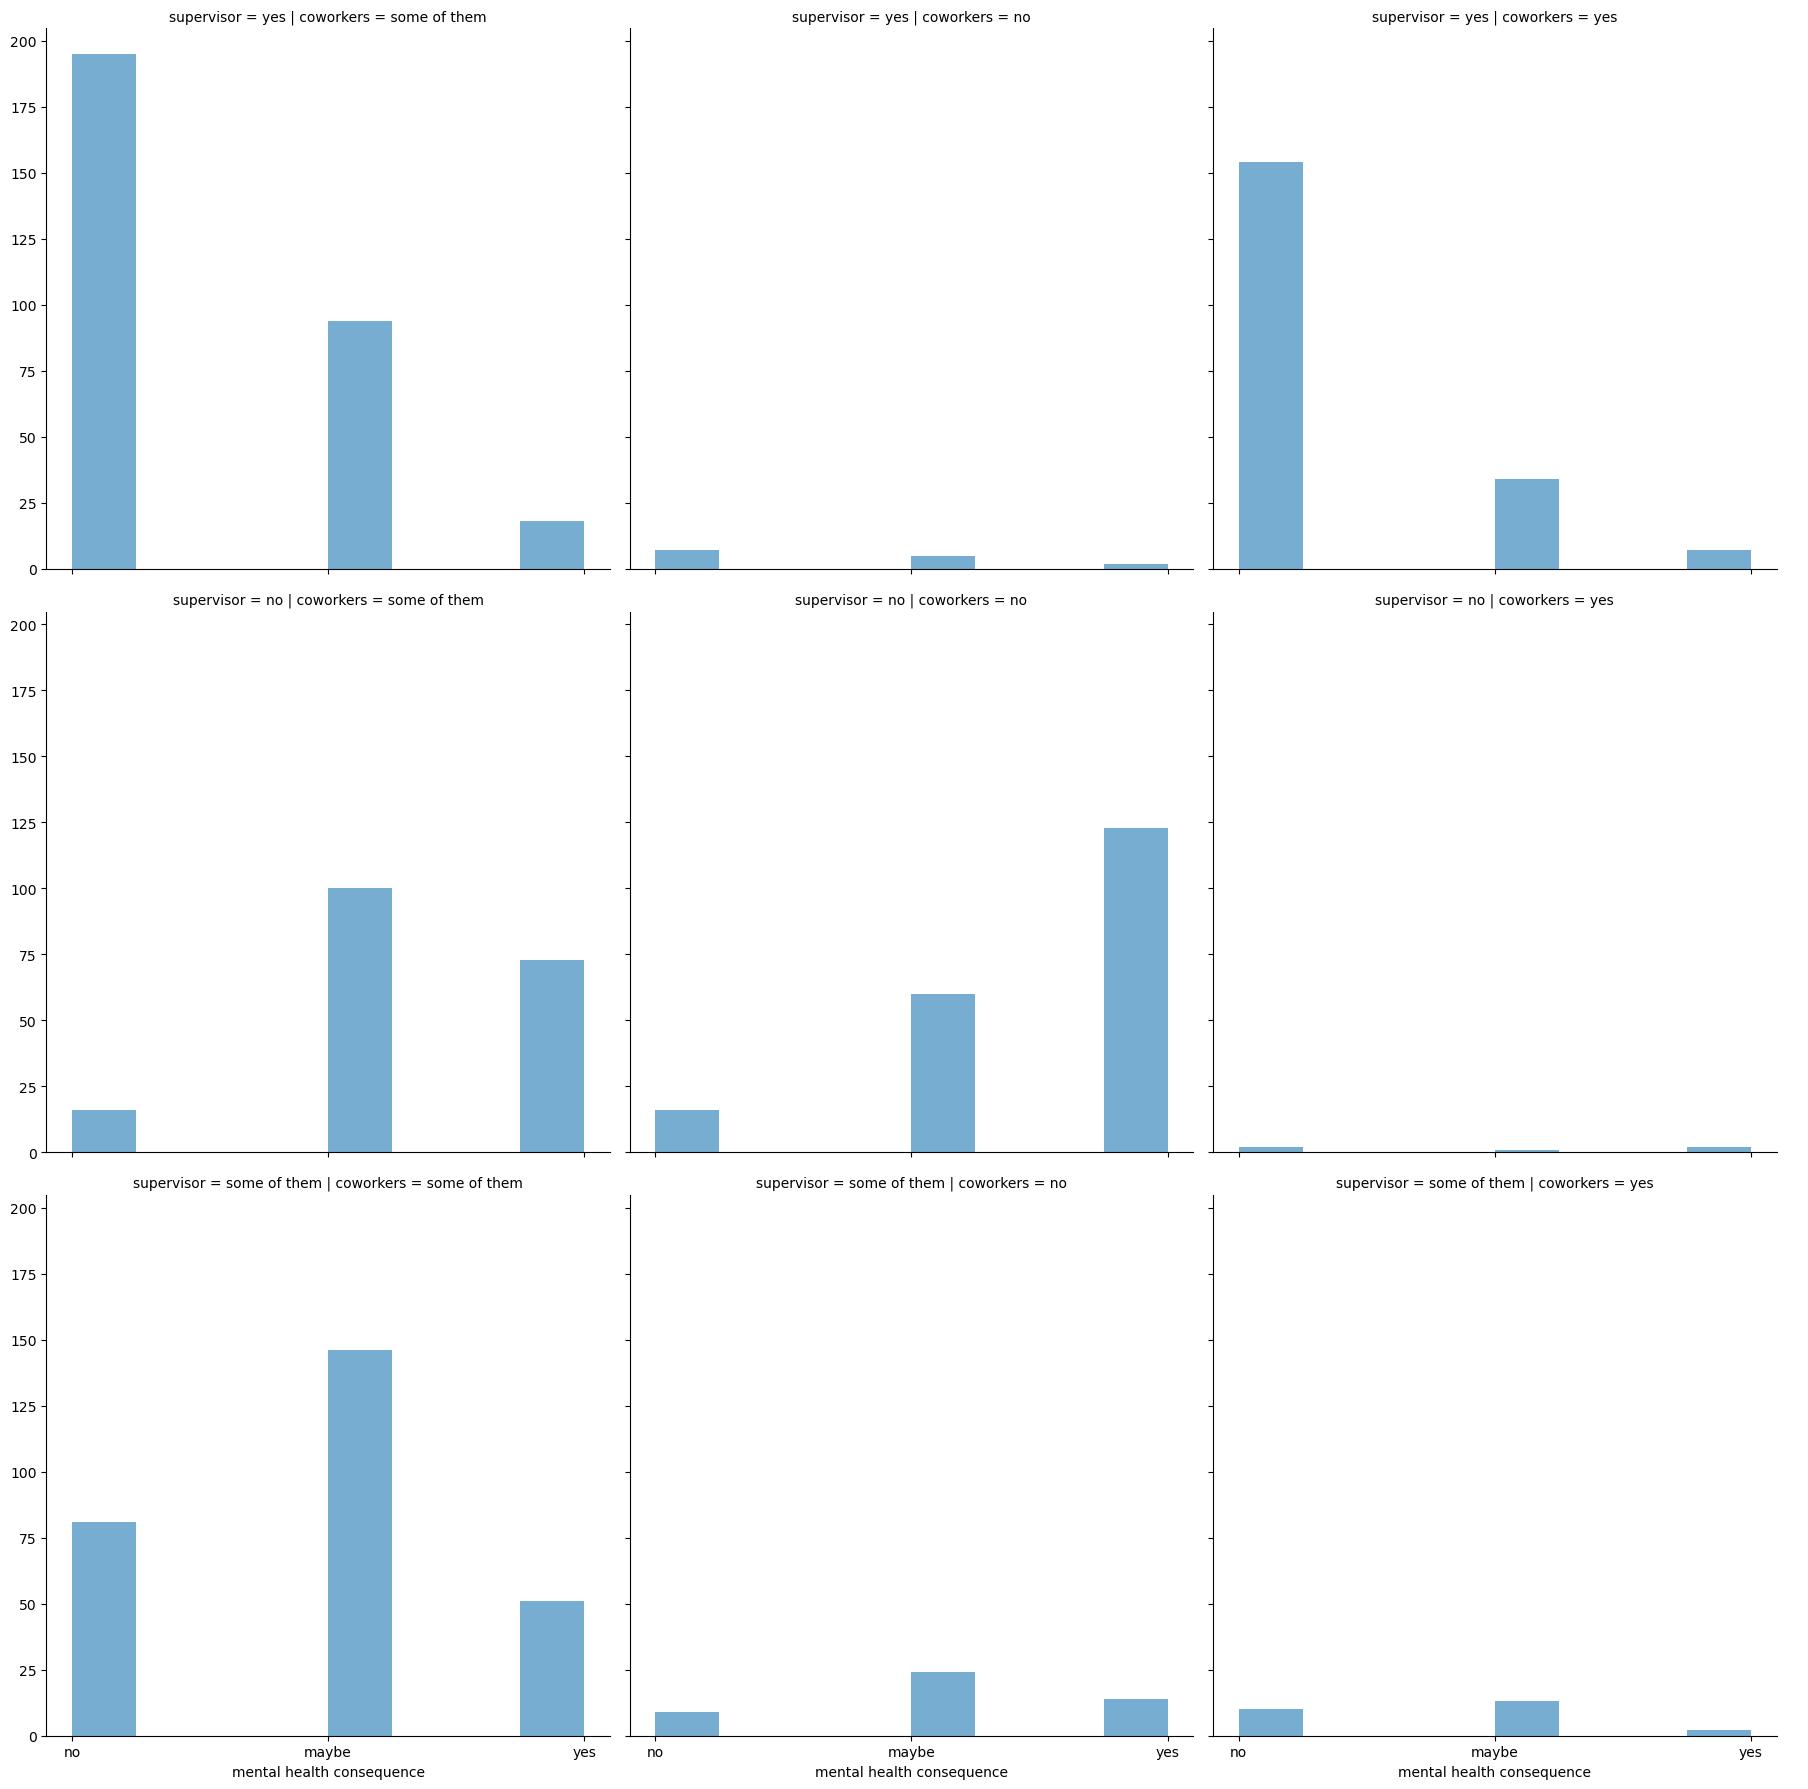

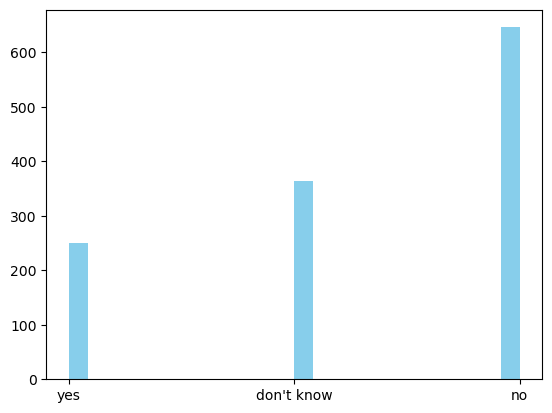

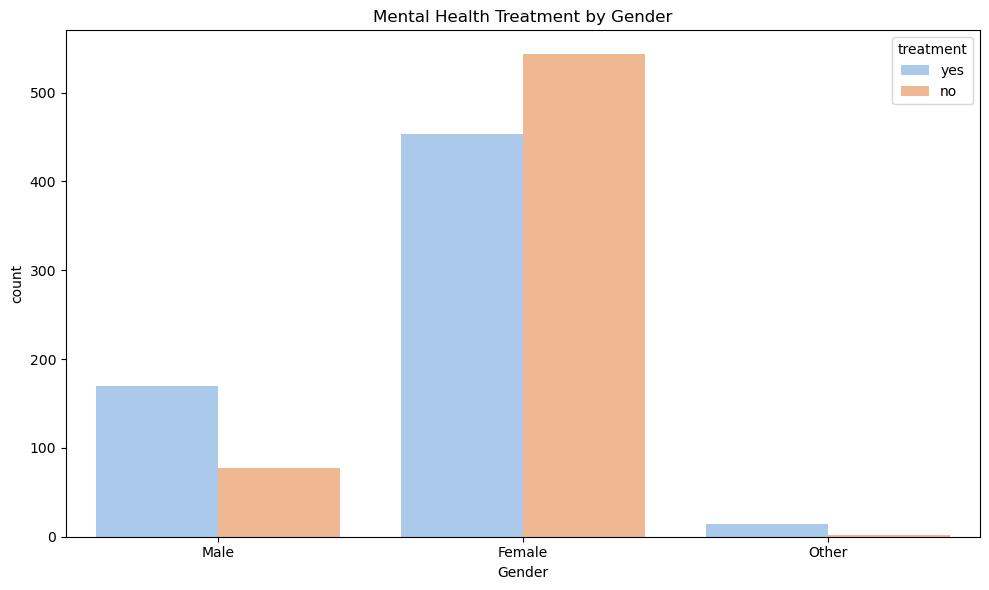

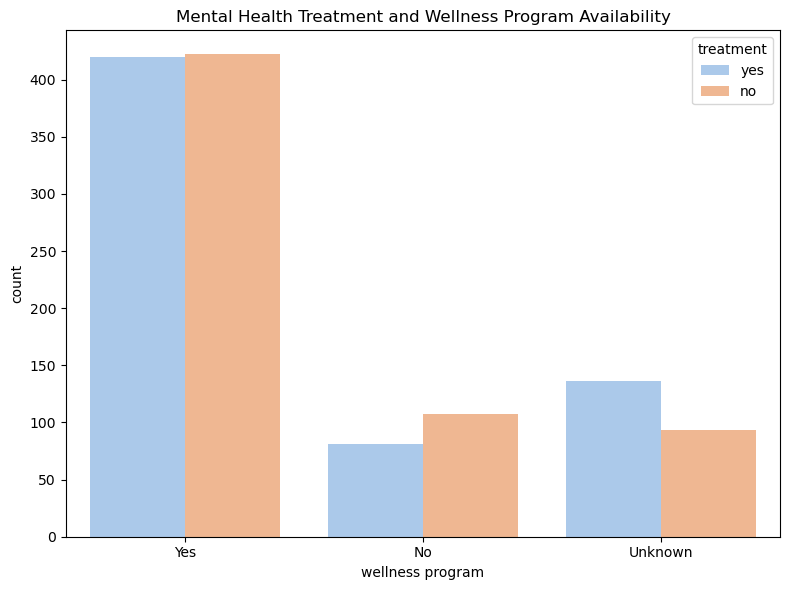

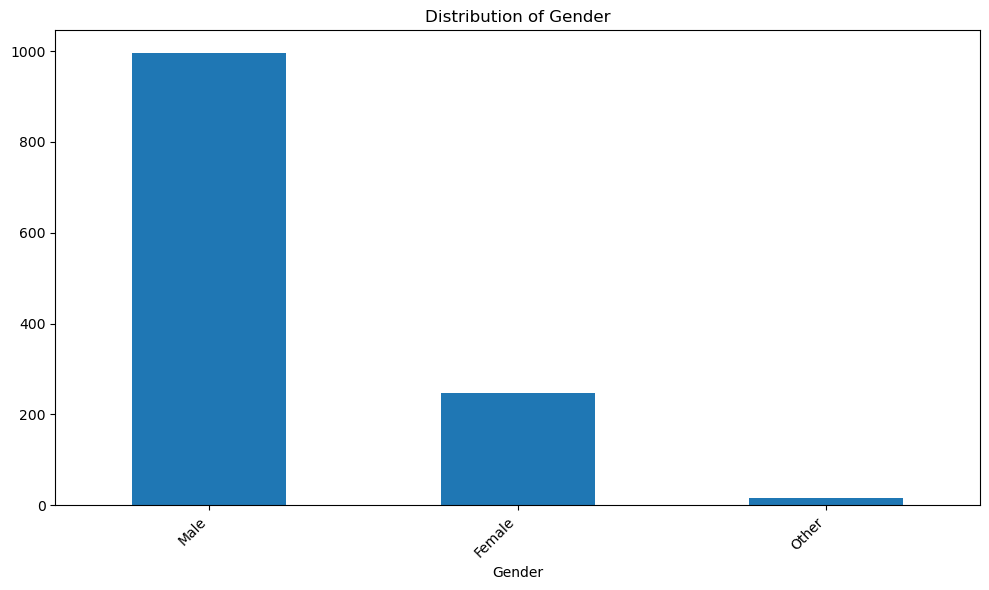

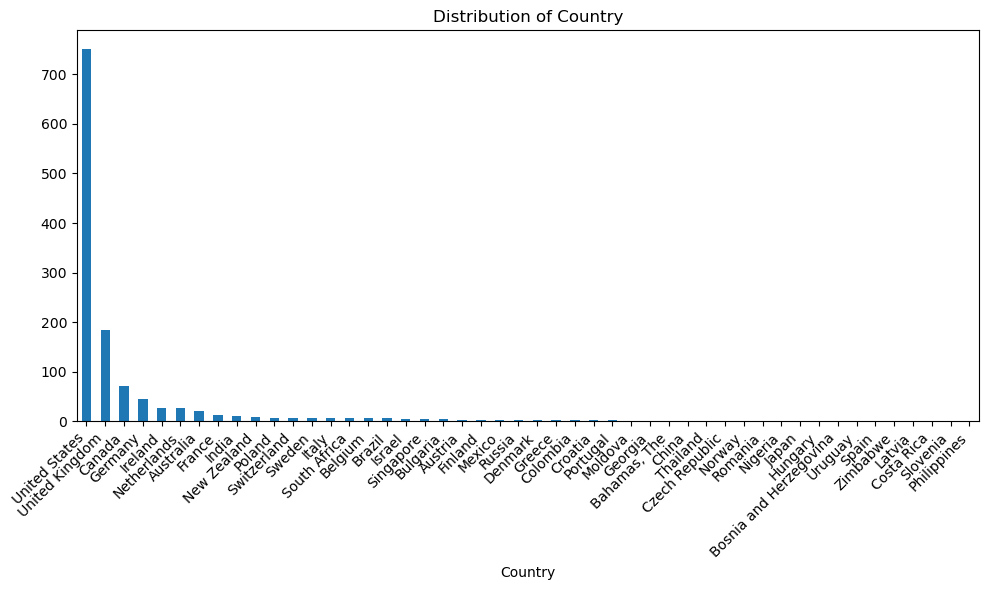

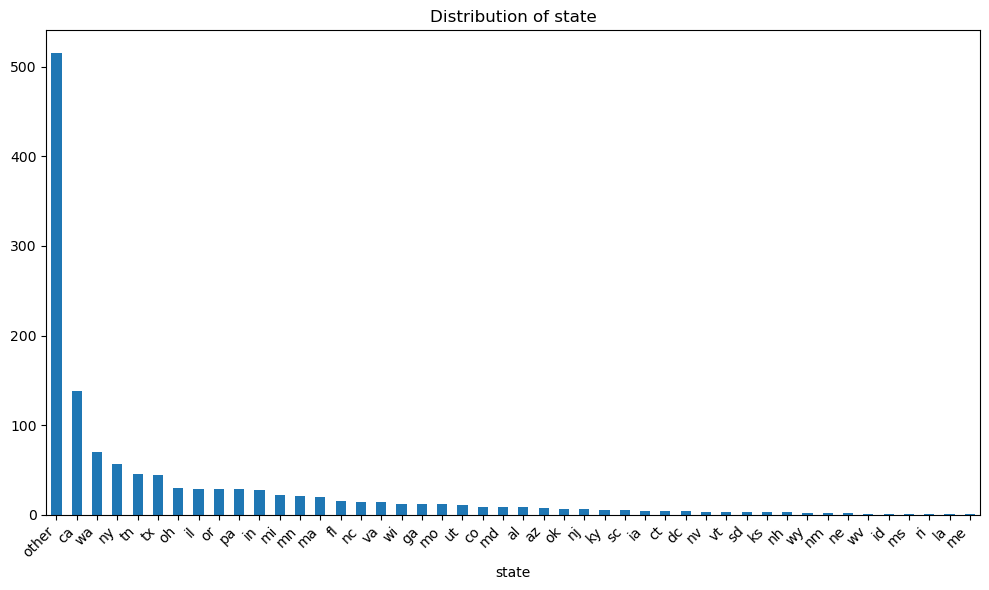

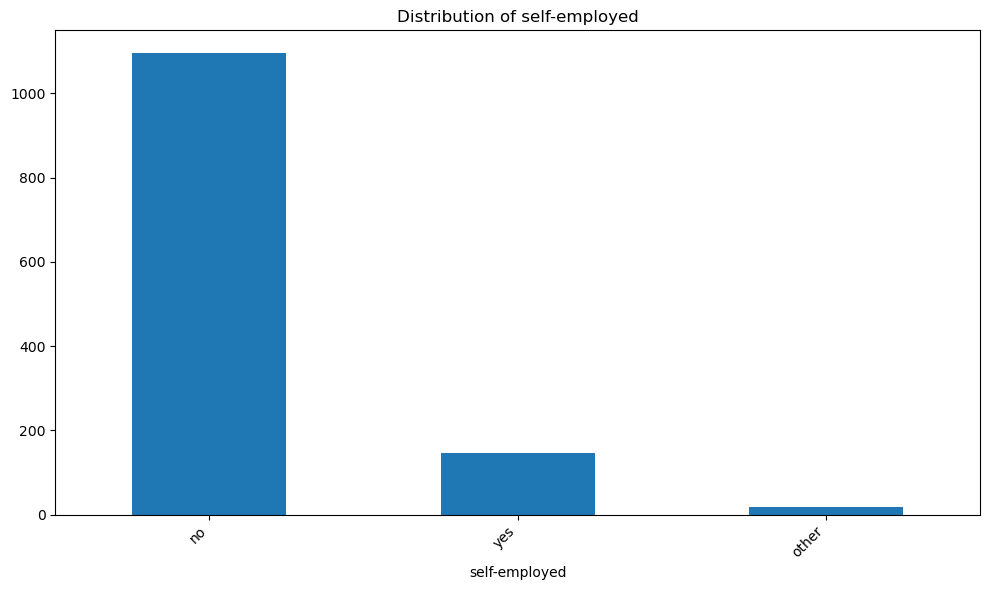

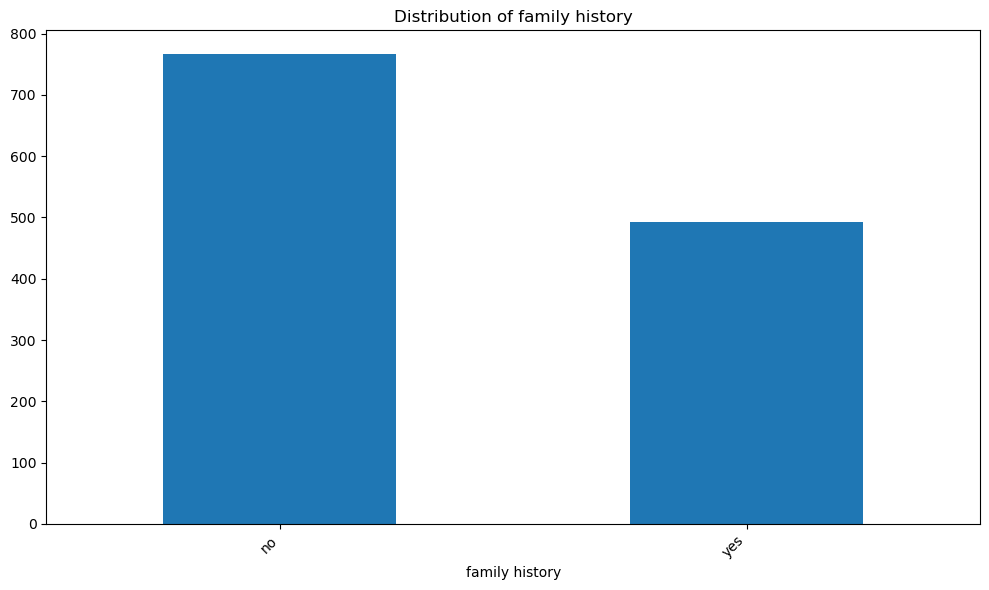

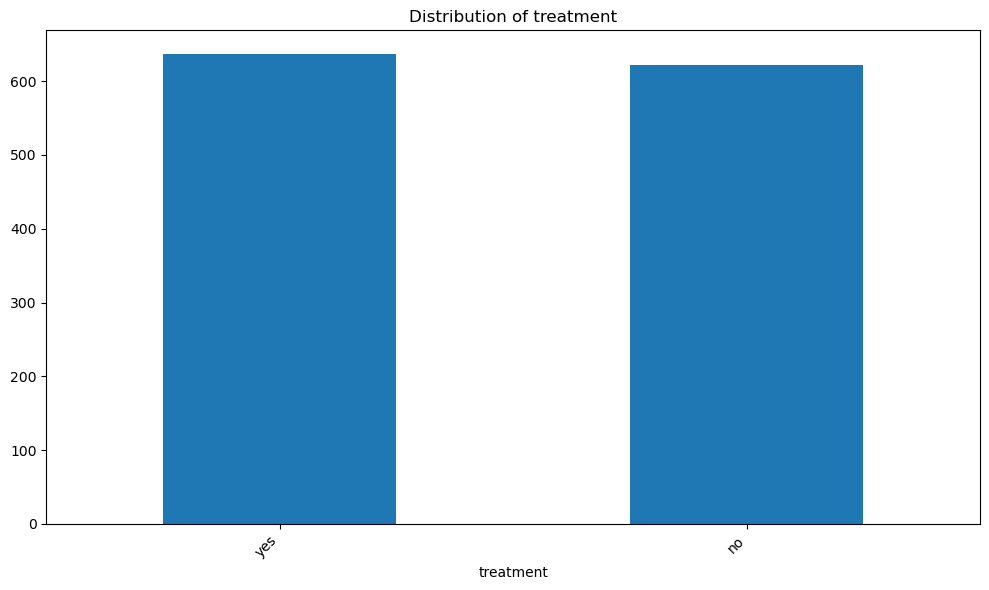

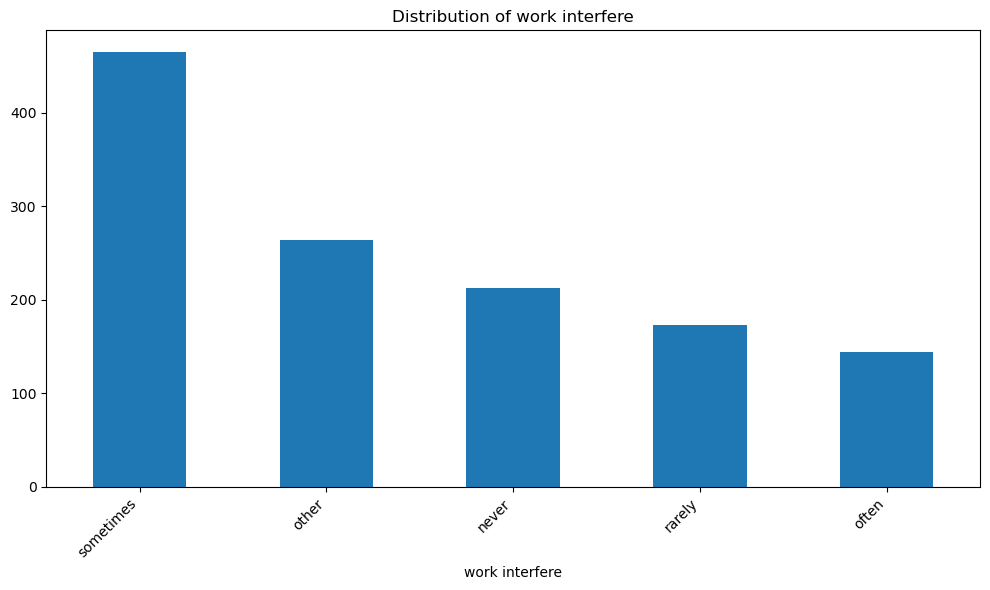

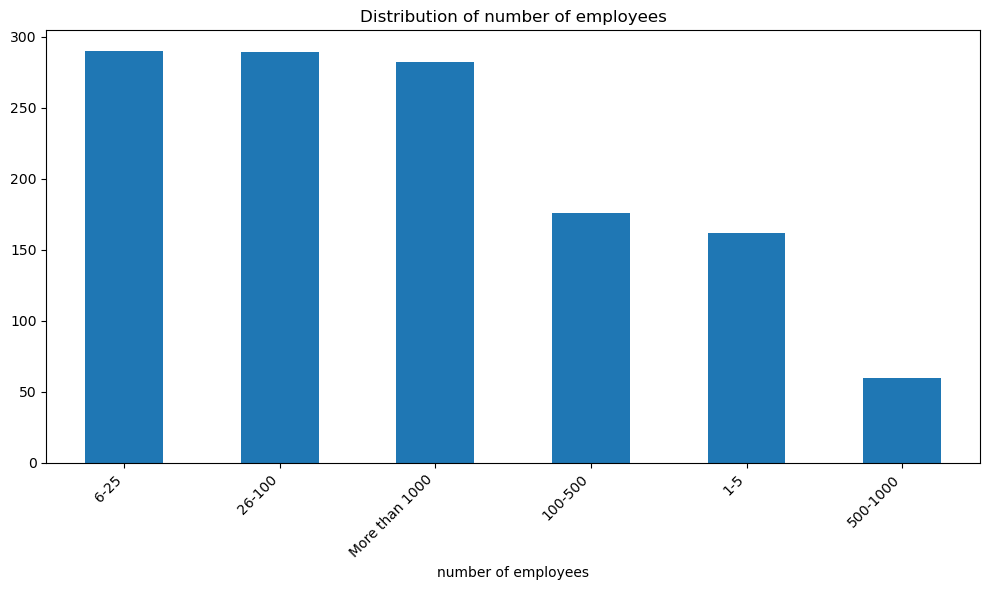

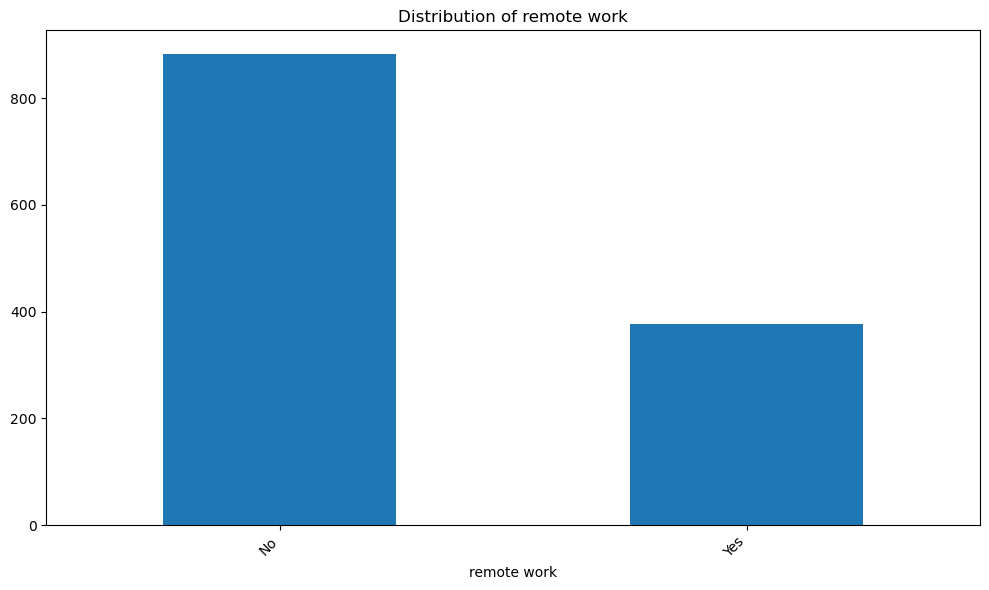

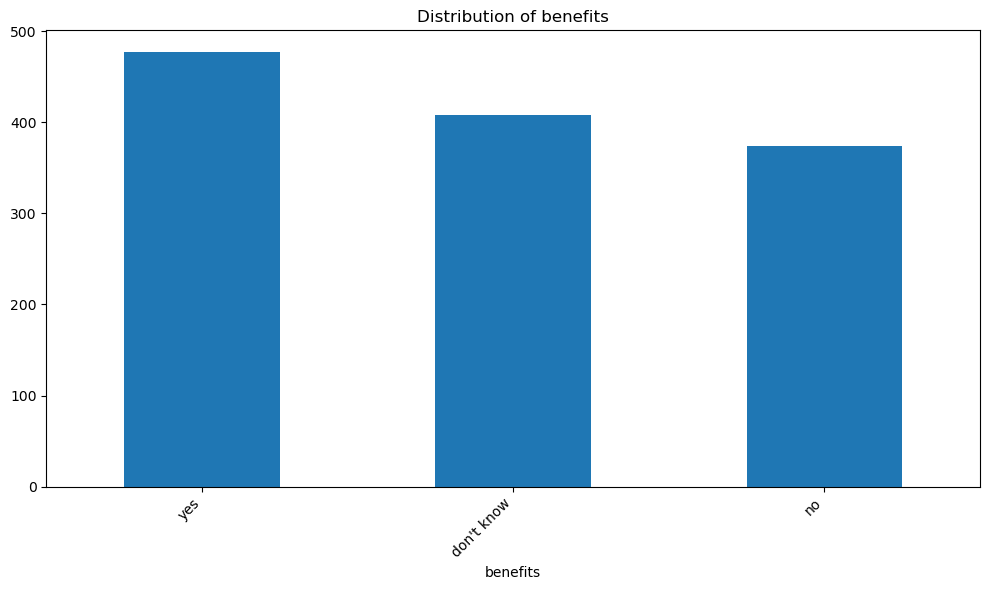

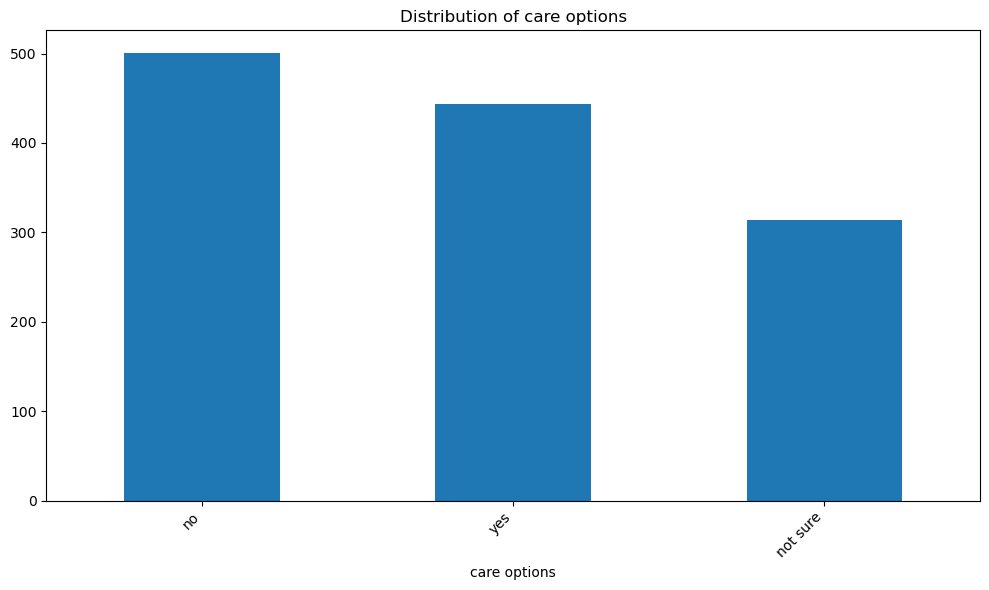

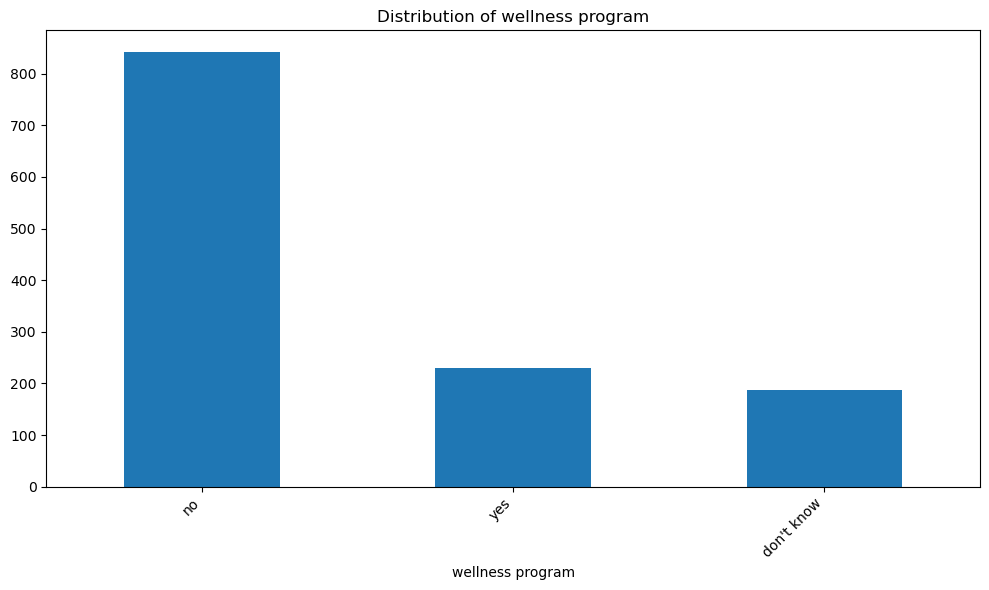

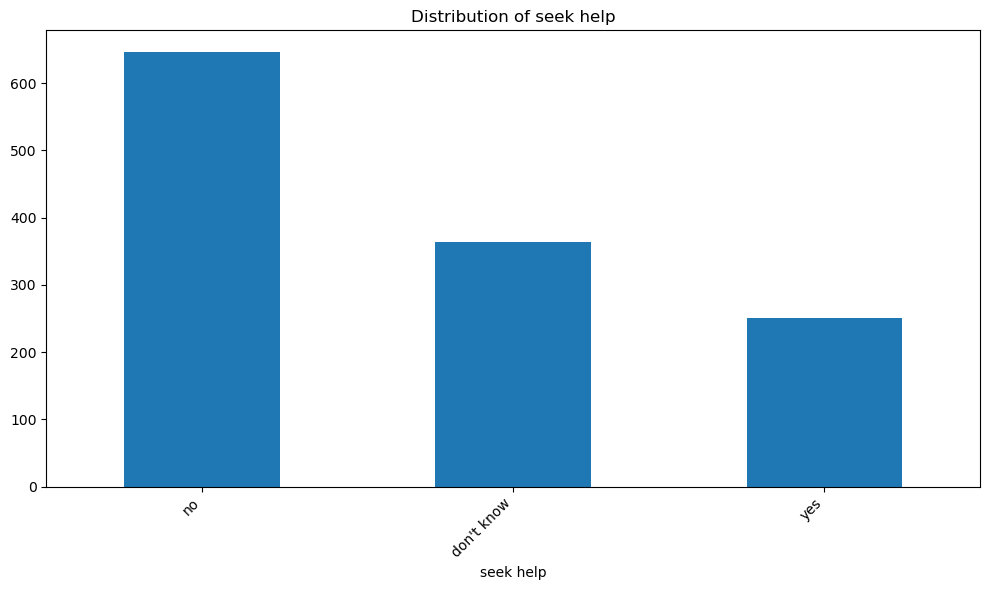

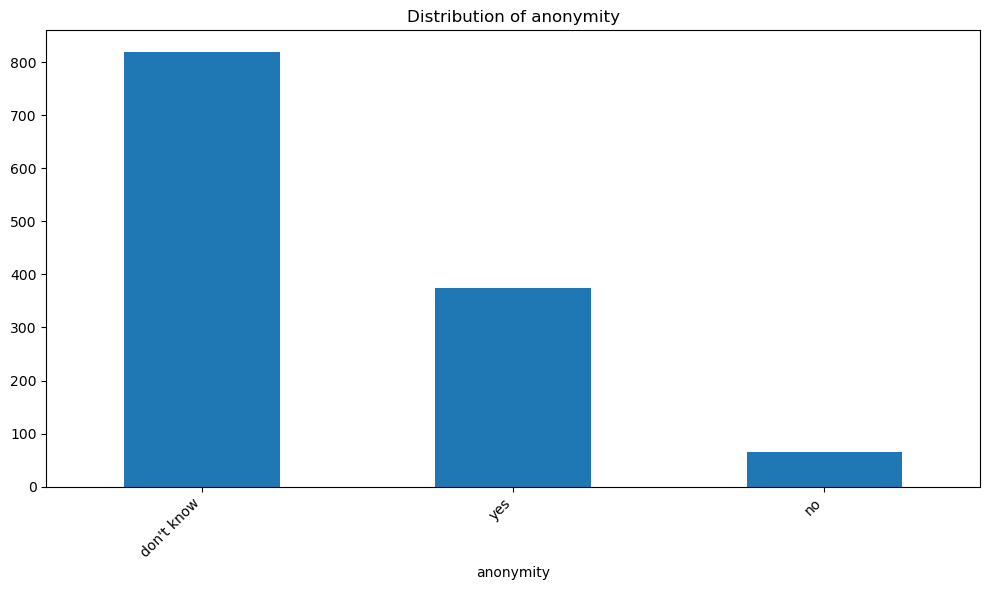

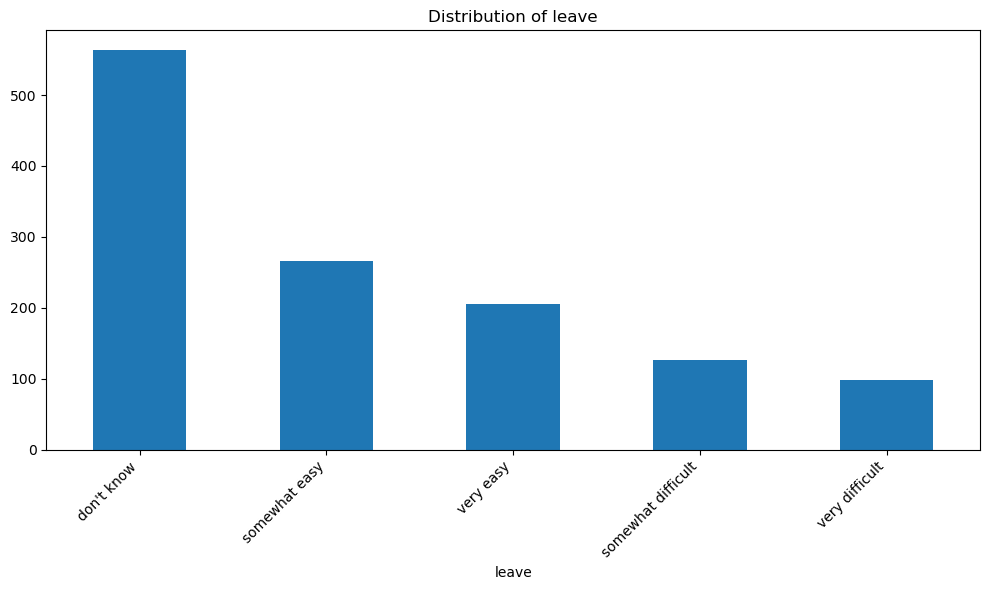

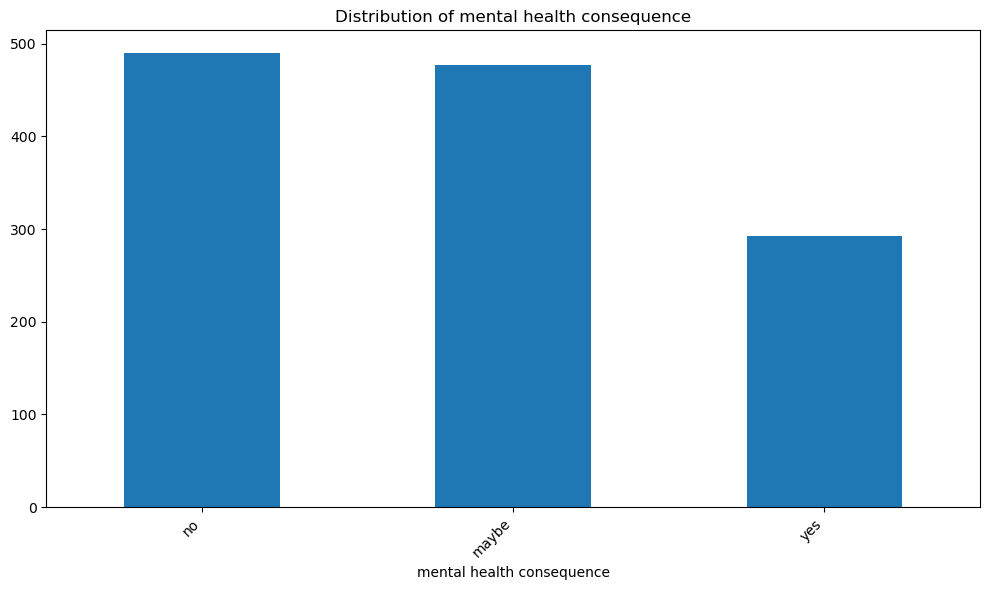

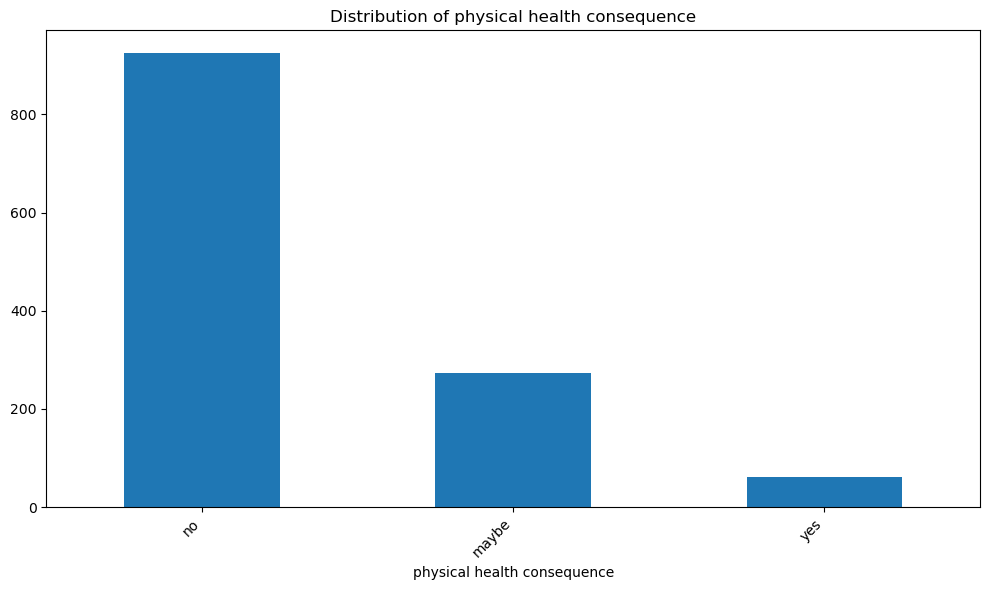

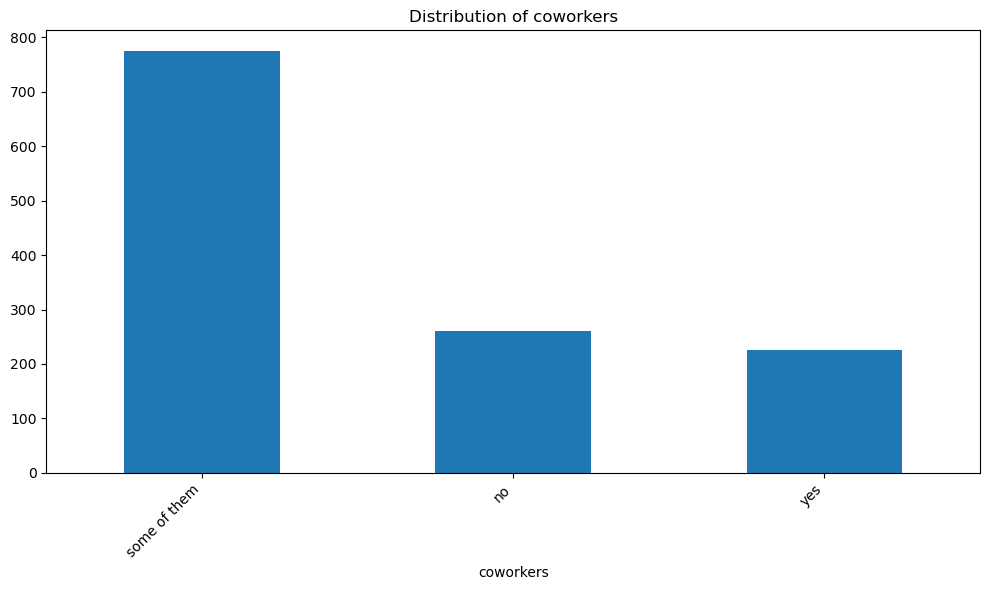

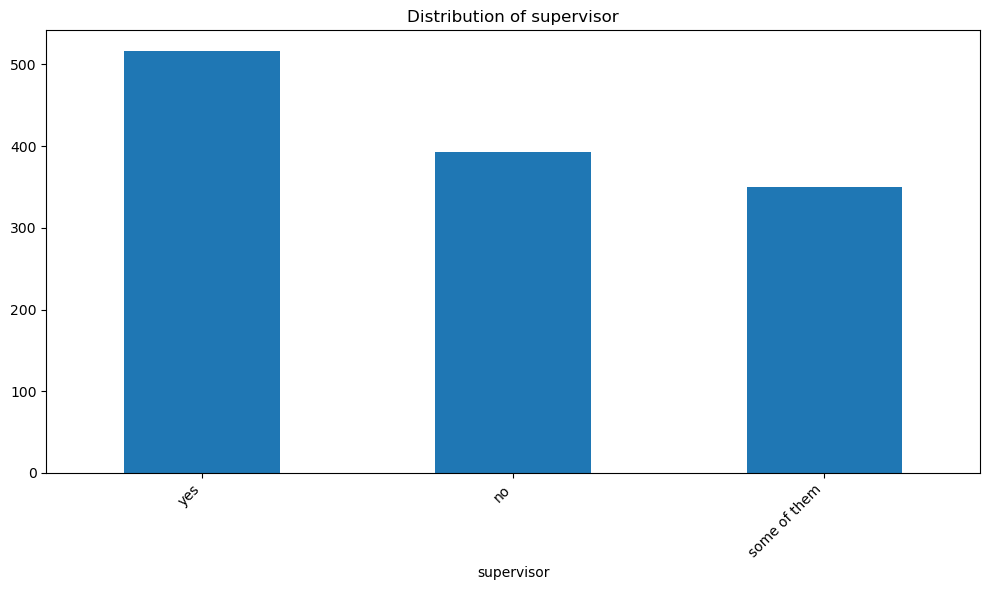

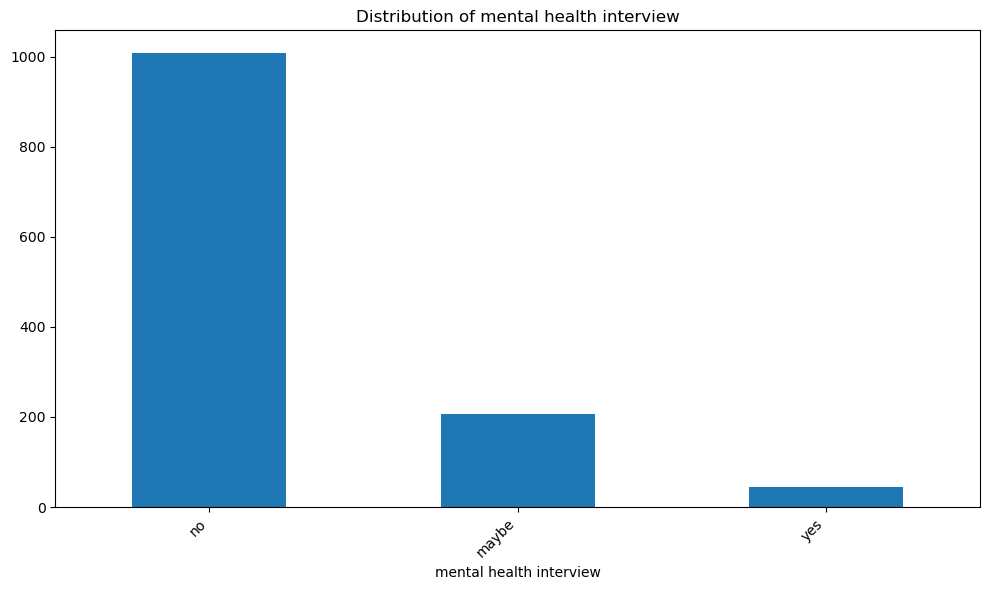

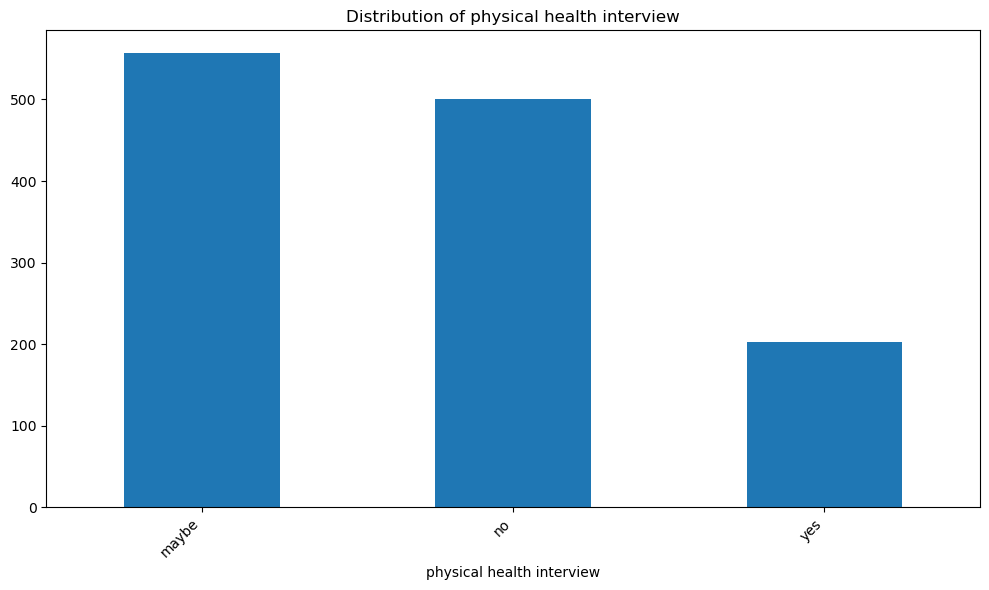

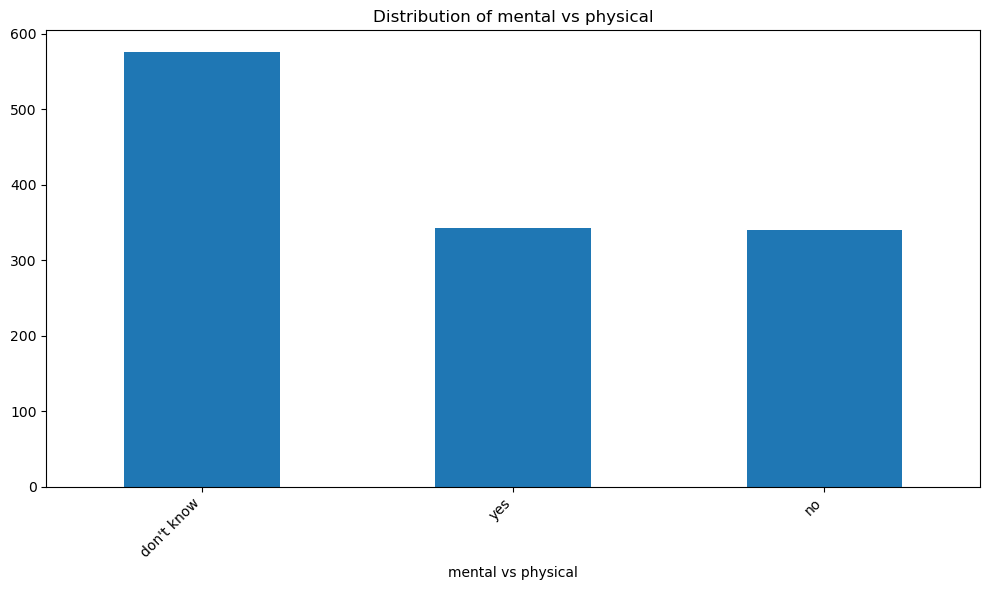

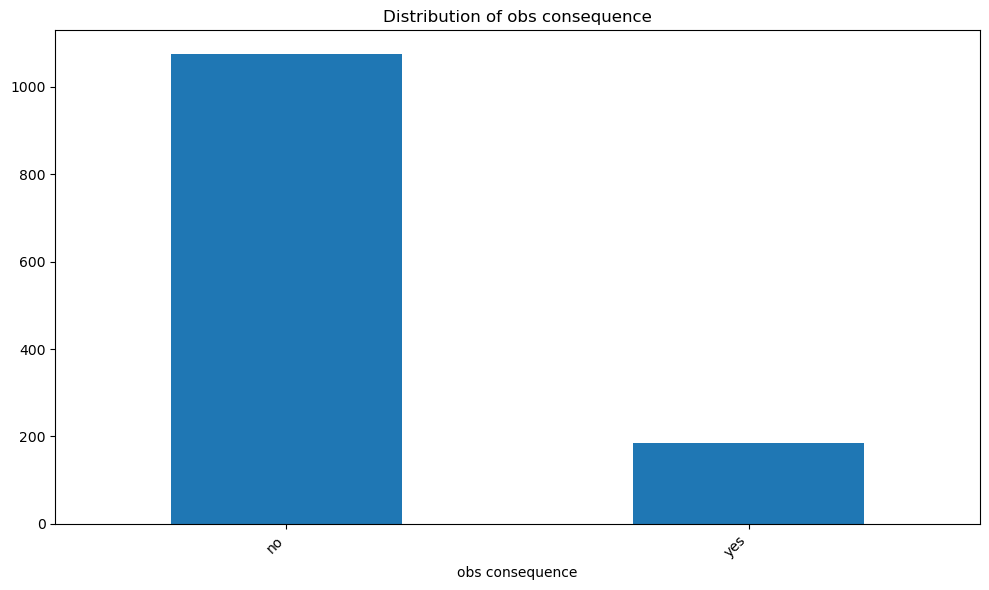

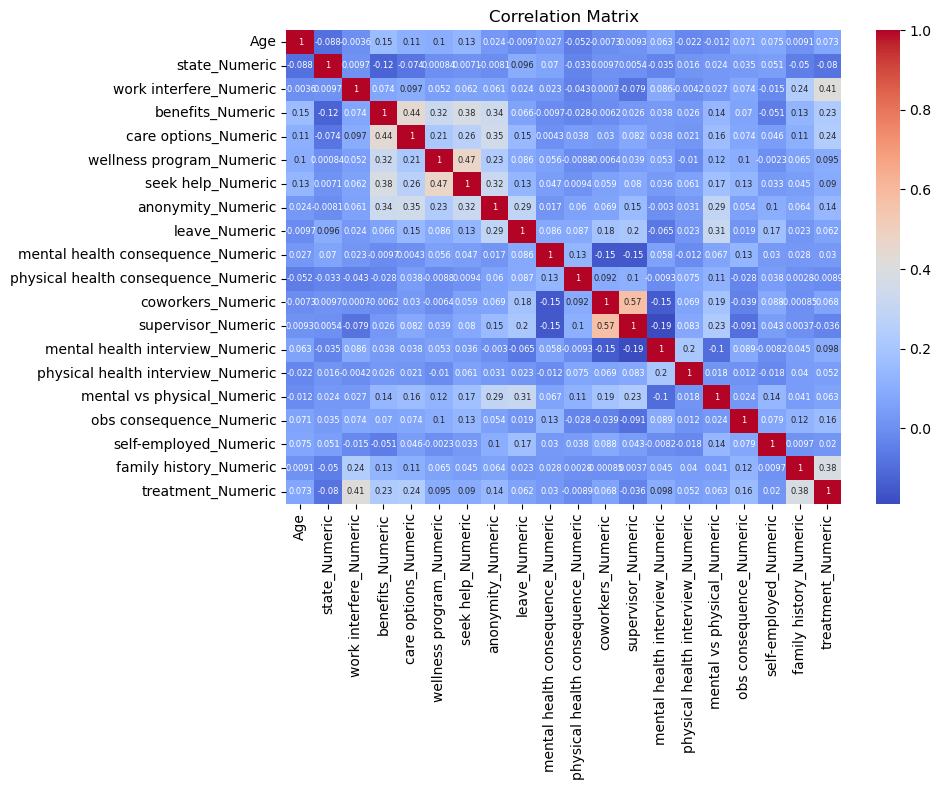

Optimization terminated successfully.
         Current function value: 0.579822
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:      treatment_Numeric   No. Observations:                 1259
Model:                          Logit   Df Residuals:                     1255
Method:                           MLE   Df Model:                            3
Date:                Thu, 07 Nov 2024   Pseudo R-squ.:                  0.1634
Time:                        17:57:55   Log-Likelihood:                -730.00
converged:                       True   LL-Null:                       -872.58
Covariance Type:            nonrobust   LLR p-value:                 1.608e-61
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -2.5949      0.322     -8.067      0.000      -3.225      

In [1]:
# Dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder
import plotly.express as px  # For interactive map

data_frames = []

data_paths = [
r'C:\Users\asg_a_1p8y6mm\OneDrive\Desktop\WIOA Training\DataAnalytics\Module 7\Module 7; Class Project\Data Cleaning 2014\survey.csv'
]

col_renames = {
       'Age':'Age', 'Gender':'Gender', 'Country':'Country', 'state':'state', 'self_employed':'self-employed',
       'family_history':'family history', 'treatment':'treatment', 'work_interfere':'work interfere', 'no_employees':'number of employees',
       'remote_work':'remote work', 'tech_company':'tech company', 'benefits':'benefits', 'care_options':'care options',
       'wellness_program':'wellness program', 'seek_help':'seek help', 'anonymity':'anonymity', 'leave':'leave',
       'mental_health_consequence':'mental health consequence', 'phys_health_consequence':'physical health consequence', 'coworkers':'coworkers',
       'supervisor':'supervisor', 'mental_health_interview':'mental health interview', 'phys_health_interview':'physical health interview',
       'mental_vs_physical':'mental vs physical', 'obs_consequence':'obs consequence',
}

col_to_keep = col_renames.keys()

for path in data_paths:
  print("\nReading file: ", path)
  df = pd.read_csv(path)
  print('Shape - default: ', df.shape)

  # We have a lot of columns and many with a lot of missing values. let's filter those columns and keep only those who have less than 90% missing values.
  max_na_filter = (0.9 * len(df))
  df = df.loc[:,(df.isnull().sum(axis = 0) <= max_na_filter)]
  print('Shape - filtered: ', df.shape)

  # Removing not needed columns
  col_to_drop = [item for item in df.columns if item not in col_to_keep]
  df.drop(columns = col_to_drop, inplace = True, errors = 'ignore')
  print('Shape - column filtered: ', df.shape)

  # Renaming columns
  df.rename(columns = col_renames, inplace = True) 

  # Storing data frames in list
  data_frames.append(df)

data_df = pd.concat(data_frames, ignore_index = True)
print('Shape - combined data: ', data_df.shape)
print('Shape - combined data: ', df.shape)

print(data_df.head(10))

# lets check number of empty rows in data
print(data_df.isna().sum().sort_values())

#### Data Cleaning and Preprocessing

# Focus on tech-related employees 
# Since we are targetting tech related employees, setting default input values will make incorrect analysis, 
# hence removing the empty value rows 
# data_df = data_df[data_df['tech company'].notna()]
data_df.dropna(subset=['tech company'], inplace=True)
# Lets see the values in our interested column
# print(data_df['tech company'].value_counts())
print(data_df.value_counts(subset=['tech company']))
# Lets remove those records who do not have tech related job
data_df.drop(data_df[data_df['tech company'] == 0.0].index, inplace = True)
# now since all of our data contains records who have tech related job, we can safely remove the column
data_df.drop(columns = 'tech company', inplace = True)
df = data_df
print(df.head())

# Handle missing values strategically
#df['self-employed'].fillna('Other', inplace=True)
df.fillna({'self-employed':'Other'}, inplace=True)
#df['state'].fillna('Other', inplace=True)
df.fillna({'state':'Other'}, inplace=True)
#df['work interfere'].fillna('Other', inplace=True)
df.fillna({'work interfere':'Other'}, inplace=True)

# Handle Age outliers
# lets see what values we have
print(data_df['Age'].describe().astype(int))
# We can see irregularites in age, lets try to address these
df['Age'] = df['Age'].astype(float)
mean_age = df[(df['Age'] >= 18) & (df['Age'] <= 75)]['Age'].mean()
df.loc[(df['Age'] < 18) | (df['Age'] > 75), 'Age'] = mean_age
print(data_df['Age'].describe().astype(int))

#### Standardize Categorical Features

# Standardize Gender
# a lot of inconsistent records exists in our gender, lets break all these in our required groups.
gender_male = ['male', 'M', 'Make', 'Male ', 'Man', 'Cis Male', 'msle', 'male leaning androgynous', 'Mail', 'Malr', 'Cis Man', 'Guy (-ish) ^_^', 'ostensibly male, unsure what that really means', 'Male (CIS)', 'Mal', 'maile', 'Male-ish', 'Androgyne', 'something kinda male?', 'm', 'man', 'male/he/him', 'let\'s keep it simple and say \"male\"', 'mostly male', 'masculine', 'identify as male', 'masculino', 'cishet male', 'cis male', 'mail', 'male-ish', 'cis-male', 'male (cis)', 'cis hetero male', 'dude', 'cisgender male', 'male, born with xy chromosoms', 'swm', 'ostensibly male']
gender_female = ['female', 'f', 'F', 'woman', 'Woman', 'Female ', 'Female (cis)', 'cis-female/femme', 'Femake', 'Cis Female', 'female, she/her', 'femile', 'female (cis)', 'f, cisgender', 'cisgendered woman', 'femmina', 'cis female', 'cis woman', 'cis-female', 'genderqueer demigirl', 'female (cisgender)', 'my sex is female.', 'femail', 'femalw', 'nonbinary/femme', 'cisgender female', 'she/her/they/them', '*shrug emoji* (f)',  'female/gender non-binary.', 'i identify as female']
gender_other = ['agender', 'Female (trans)', 'Genderqueer', 'A little about you', 'queer', 'Neuter', 'Trans woman', 'Agender', 'fluid', 'Enby', 'All', 'Nah', 'queer/she/they', 'Trans-female', 'p', 'nonbinary', 'nb', 'b', 'gender non-conforming woman', 'demiguy', 'trans non-binary/genderfluid', 'other', 'afab non-binary', 'sometimes', 'questioning', 'none', 'trans man', 'trans woman', 'trans female', 'non-binary/agender', 'make', 'agender trans woman', 'transfeminine', 'genderqueer/non-binary', 'non binary', 'contextual', 'agender/genderfluid', 'non-binary', 'genderfluid', 'god king of the valajar', 'uhhhhhhhhh fem genderqueer?', 'transgender', 'genderqueer', 'homem cis']
# lets transfor gender in simpler form
df['Gender'] = df['Gender'].replace(gender_male, 'Male')
df['Gender'] = df['Gender'].replace(gender_female, 'Female')
df['Gender'] = df['Gender'].replace(gender_other, 'Other')
# lets check records now
df['Gender'].value_counts()

# Standardize other categorical features
categorical_cols = ['state', 'work interfere',  'benefits', 'care options', 'wellness program', 'seek help', 'anonymity', 'leave', 'mental health consequence', 'physical health consequence', 'coworkers', 'supervisor', 'mental health interview', 'physical health interview', 'mental vs physical', 'obs consequence', 'self-employed', 'family history', 'treatment']
for col in categorical_cols:
    df[col] = df[col].str.lower().str.strip()  # Apply lowercasing and whitespace removal
# Convert ALL Categorical Features to Numeric Representations
label_encoder = LabelEncoder()
for col in categorical_cols:
    df[col + '_Numeric'] = label_encoder.fit_transform(df[col])

# Standardize Benefits
# lets check number of empty rows in data again
print(df.isna().sum().sort_values())
# we dont have any missing rows now, lets first see what are different values present
print(df['benefits'].value_counts())
# Not eligible for coverage / NA is same as No. Lets update
df.loc[df['benefits'] == 'Not eligible for coverage / NA' , 'benefits'] = 'No'
print(df['benefits'].value_counts())

#### Feature Reduction
# Lets see our unique data types
print(df.nunique())
print(df.info())


##### Descriptive Statistics and Visualizations

colors = sns.color_palette('pastel')[0:5]


# age
print(data_df['Age'].describe())

# It can be seen as mostly say Yes and mostly are Men in their 30s in our data. So lets plot them together to further analyze
g = sns.FacetGrid(data_df, row='Gender', col='mental health consequence', height=4)
g.map(plt.hist, 'Age', bins=range(0, 101, 10)) # Bins from 0 to 100 with a width of 10
g.set(xlim=(0, 100))  # Set x-axis limits
g.add_legend()
plt.show()



g = sns.FacetGrid(df, row = 'supervisor', col = 'coworkers', height = 6)
g.map(plt.hist, 'mental health consequence', bins = 8, alpha = 0.6)
g.add_legend()
plt.show()

# Seek Help?
plt.hist(df['seek help'], bins=24, color = "skyblue")
plt.show()

# Relationship between Demographics/Work Factors and Mental Health
plt.figure(figsize=(10, 6))
sns.countplot(x="Gender", hue="treatment", data=df, palette="pastel")
# Set ticks and labels using plt.xticks() after the Seaborn plot
plt.xticks([0, 1, 2], ["Male", "Female", "Other"])
plt.title("Mental Health Treatment by Gender")
plt.tight_layout()
plt.show()

# Wellness Program Effectiveness
plt.figure(figsize=(8, 6))
sns.countplot(x='wellness program', hue='treatment', data=df, palette="pastel") 
plt.xticks([0, 1, 2], ["Yes", "No", "Unknown"])
plt.title("Mental Health Treatment and Wellness Program Availability")
plt.tight_layout()
plt.show()

# Distributions for all features
for col in df.columns: # Loop through all columns
    if df[col].dtype == 'object': # Categorical features
        plt.figure(figsize=(10, 6))
        df[col].value_counts().plot(kind='bar', rot=45)
        plt.title(f'Distribution of {col}')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

# Correlation Analysis (Use numeric versions of variables)
numeric_df = df.select_dtypes(include=np.number)  # Select only numeric columns for correlation
correlation_matrix = numeric_df.corr()
# Plot the results
plt.figure(figsize=(10, 8)) # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", annot_kws={"size": 6})
plt.title("Correlation Matrix")
plt.yticks(rotation=0)  # Keep y-axis labels vertical
plt.tight_layout()
plt.show()

# Regression Analysis (Example Logistic Regression. Expand and refine as needed.)
X = df[['Age', 'work interfere_Numeric', 'benefits_Numeric']]  # Select relevant predictors (numeric versions)
X = sm.add_constant(X) # Add a constant to the model
y = df['treatment_Numeric']
model = sm.Logit(y, X)
results = model.fit()
print(results.summary())

    